In [ ]:
# Install the required libraries
#SAM
#! pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
#! pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
#! pip install datasets
#! pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
#! pip install patchify
#! pip install matplotlib
#! pip install tifffile
#! pip install scipy
#! pip install opencv-python


  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl (39.5 MB)


In [116]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage
import glob
import cv2
from tqdm import tqdm

In [117]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

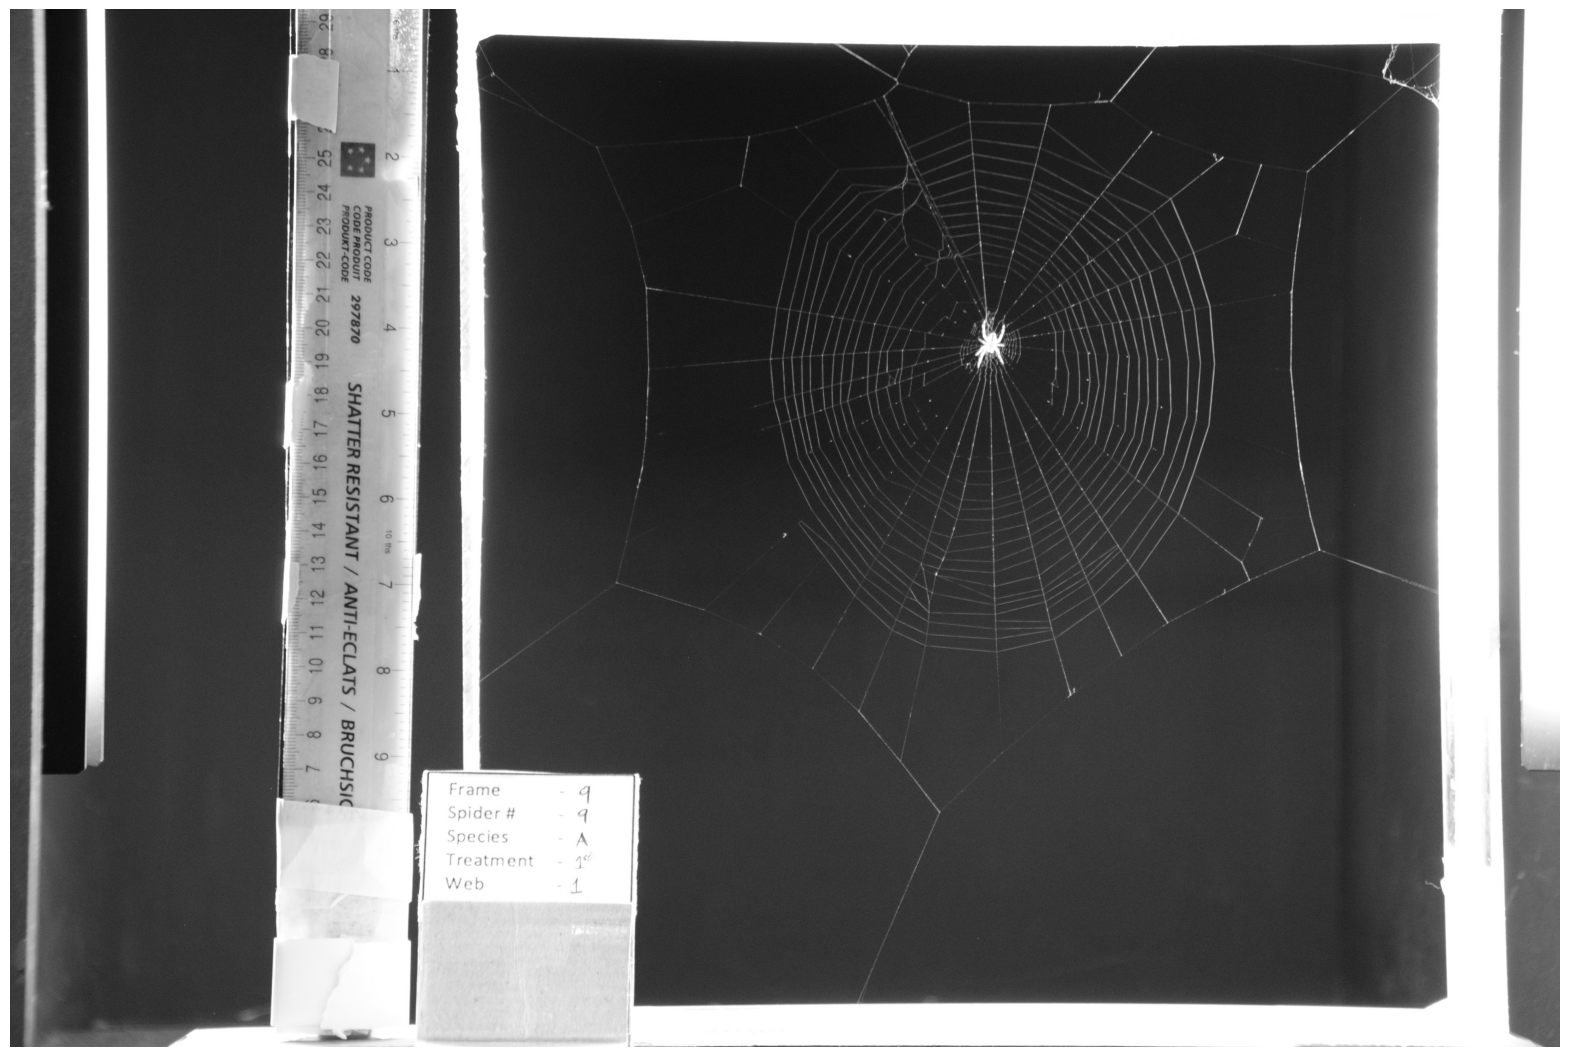

In [118]:
image = cv2.imread(r"C:\Files\Araneus diadematus\Missing leg study\Missing leg treatment\9 - 1.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [119]:
from huggingface_hub import hf_hub_download

# Download the SAM vit_h checkpoint
checkpoint_path = hf_hub_download(
    repo_id="HCMUE-Research/SAM-vit-h",       # You can also try "facebook/sam-vit-h" if available
    filename="sam_vit_h_4b8939.pth"
)

# Use it with SAM
from segment_anything import sam_model_registry
sam = sam_model_registry["vit_h"](checkpoint=checkpoint_path)

In [120]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

device = "cpu"

sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [121]:

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

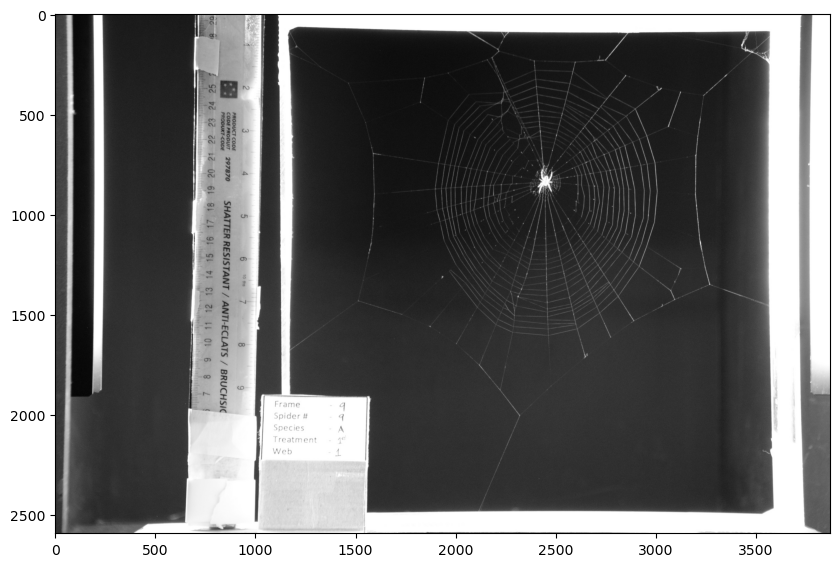

In [122]:
pointImage = cv2.imread(r"C:\Files\Araneus diadematus\Missing leg study\Missing leg treatment\9 - 1.jpg")
pointImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10,10))
plt.imshow(pointImage, cmap='gray')
plt.axis('on')
plt.show()

In [123]:
predictor = SamPredictor(sam)

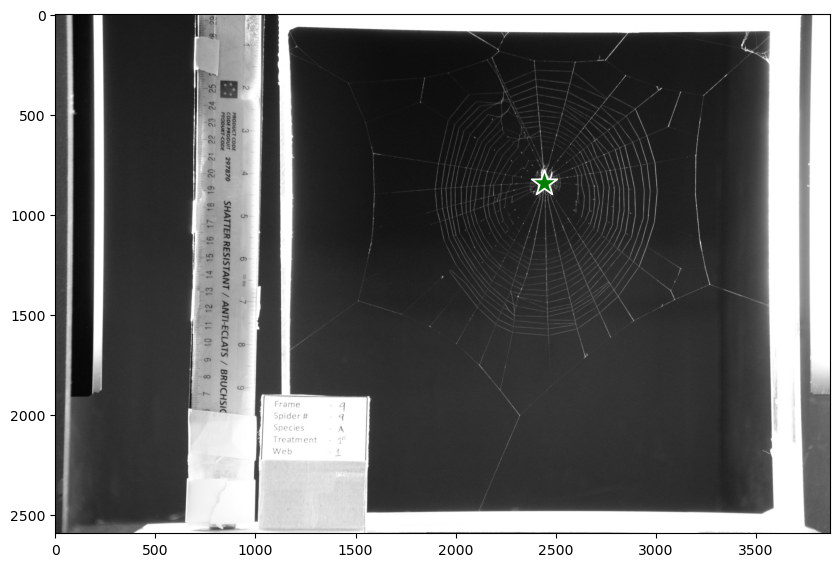

In [124]:
input_point = np.array([[2440, 840]]) #Location of spider in first image in folder
input_label = np.array([1])

plt.figure(figsize=(10,10))
plt.imshow(pointImage, cmap='gray')
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [125]:
_, thresh = cv2.threshold(pointImage, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


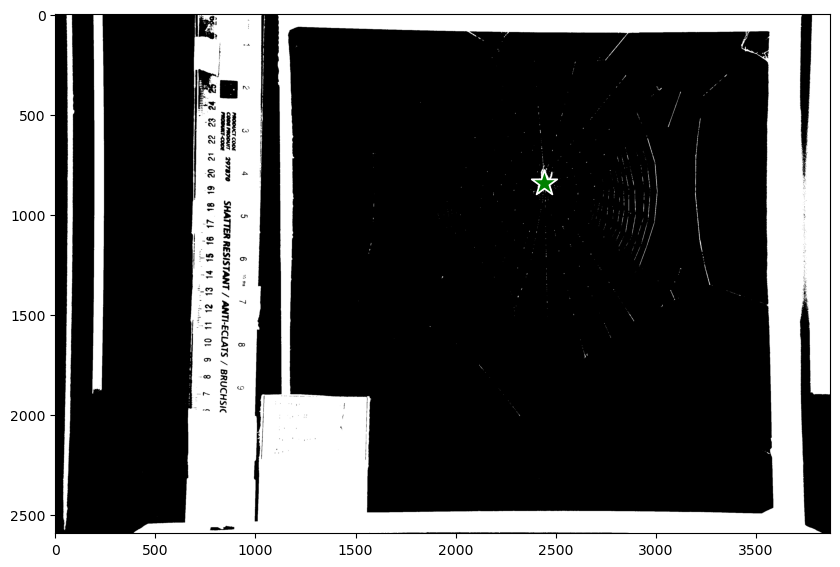

In [126]:
plt.figure(figsize=(10,10))
plt.imshow(thresh, cmap='gray')
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [127]:
rgb_thresh = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)
predictor.set_image(rgb_thresh)

In [128]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

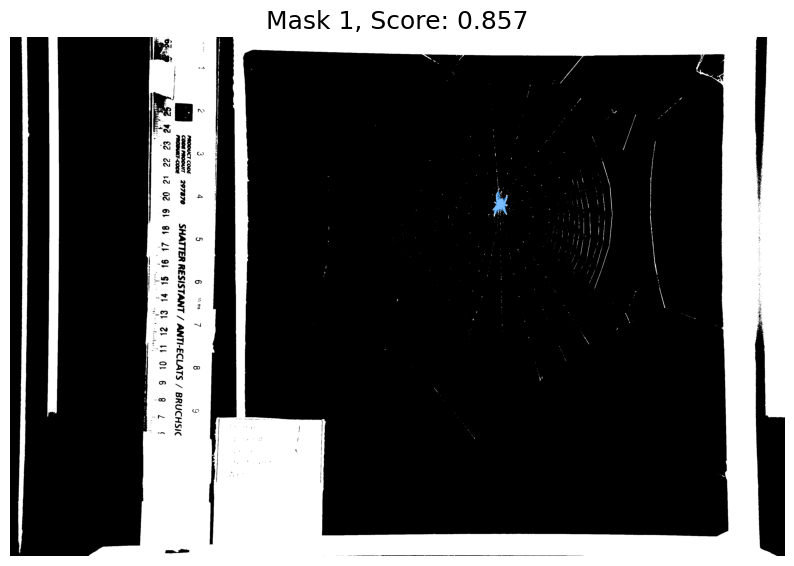

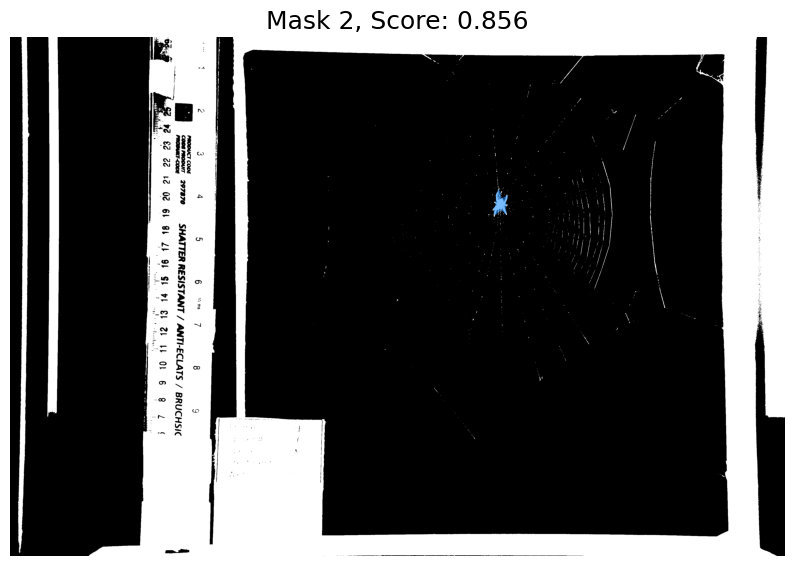

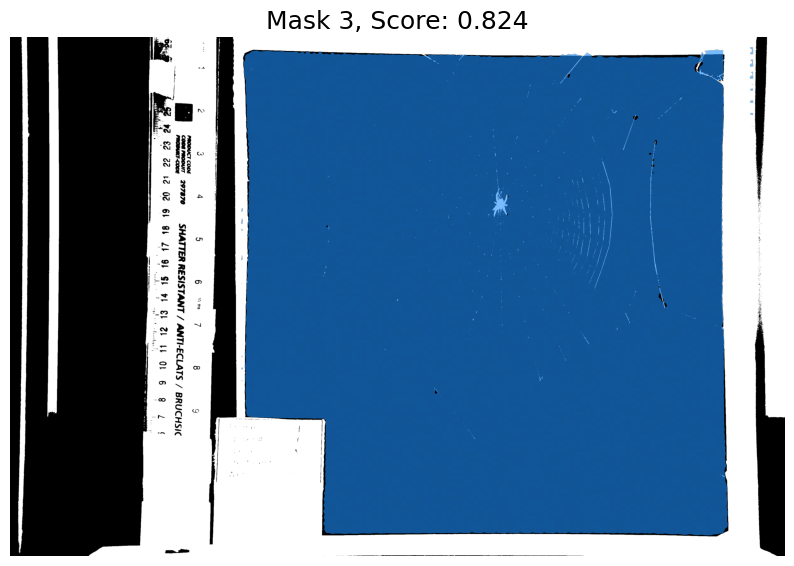

In [129]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(rgb_thresh)
    show_mask(mask, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

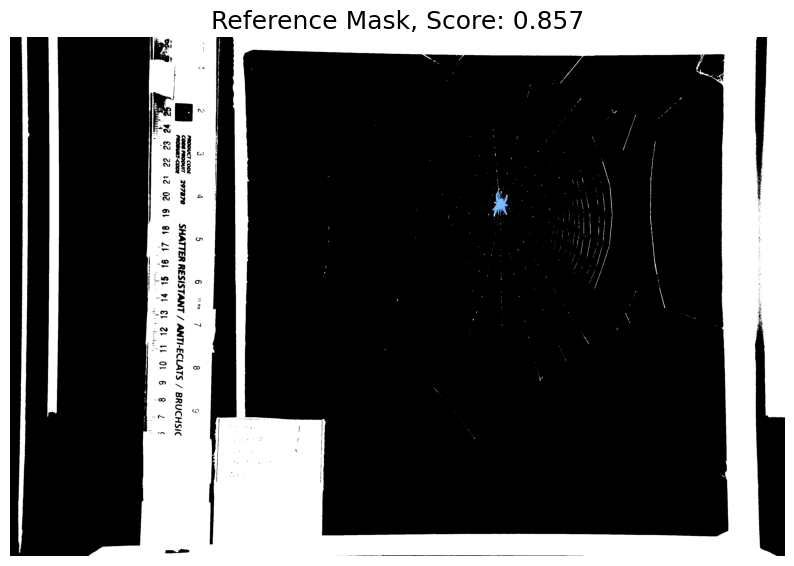

In [130]:
reference = masks[0]
referenceScore = scores[0]
plt.figure(figsize=(10,10))
plt.imshow(rgb_thresh)
show_mask(reference, plt.gca())
plt.title(f"Reference Mask, Score: {referenceScore:.3f}", fontsize=18)
plt.axis('off')
plt.show()  

In [135]:
def crop_to_mask_circle(image, mask, padding=10):
    """
    Crop the image to the smallest enclosing circle around the non-zero region in the mask.

    Parameters:
        image (np.ndarray): Original image (H, W, C)
        mask (np.ndarray): Binary mask (H, W) where non-zero values define the region of interest
        padding (int): Optional padding around the circle (in pixels)

    Returns:
        cropped_image (np.ndarray): Cropped image around the circular region
    """
    # Ensure mask is binary
    mask = (mask > 0).astype(np.uint8)

    # Get coordinates of the non-zero mask area
    points = cv2.findNonZero(mask)
    if points is None:
        return None  # or raise an exception

    # Find the smallest enclosing circle
    (x, y), radius = cv2.minEnclosingCircle(points)

    # Add padding
    x, y, radius = int(x), int(y), int(radius + padding)

    # Compute square bounding box
    x1 = max(x - radius, 0)
    y1 = max(y - radius, 0)
    x2 = min(x + radius, image.shape[1])
    y2 = min(y + radius, image.shape[0])

    # Crop the image
    cropped_image = image[y1:y2, x1:x2]
    cropped_mask = mask[y1:y2, x1:x2]

    return cropped_image, cropped_mask


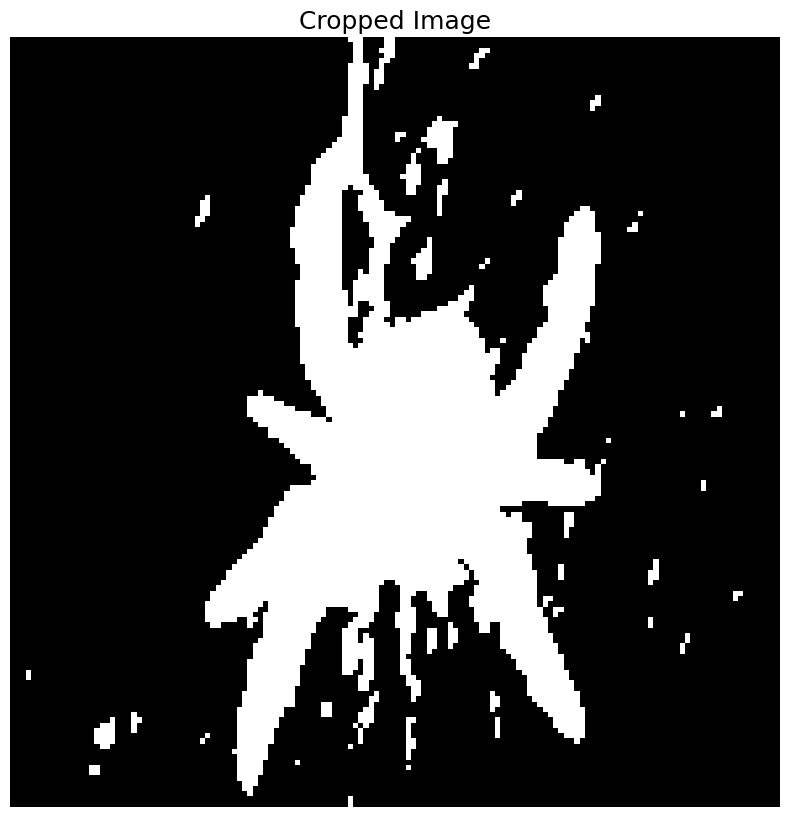

In [136]:
crop, cropMask = crop_to_mask_circle(rgb_thresh, reference)

plt.figure(figsize=(10,10))
plt.imshow(crop)
plt.title(f"Cropped Image", fontsize=18)
plt.axis('off')
plt.show()  

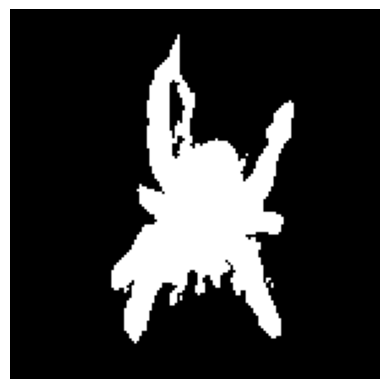

In [137]:
reference = reference.astype(np.uint8) * 255
if reference.shape != crop.shape:
    reference = cv2.resize(reference, (crop.shape[1], crop.shape[0]))


spider_only = cv2.bitwise_and(crop, crop, mask=cropMask)
plt.imshow(spider_only, cmap='gray'), plt.axis("off")
plt.show()

In [145]:
# Ensure grayscale
if len(spider_only.shape) == 3:
    spider_only = cv2.cvtColor(spider_only, cv2.COLOR_BGR2GRAY)

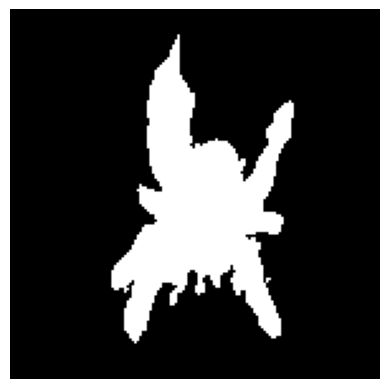

In [146]:
contours, _ = cv2.findContours(spider_only, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

edited = np.zeros_like(spider_only)
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    area = cv2.contourArea(cnt)
    aspect_ratio = float(w) / h if h != 0 else 0

    if area > 500 and aspect_ratio < 4:  # keep only “chunkier” shapes
        cv2.drawContours(edited, [cnt], -1, 255, thickness=cv2.FILLED)
plt.imshow(edited, cmap='gray'), plt.axis("off")
plt.show()

Estimated leg roots from convexity defects: 5


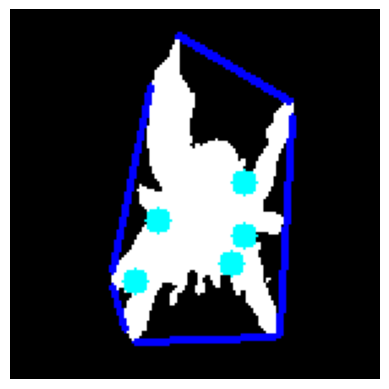

In [170]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Find the biggest contour (the spider)
contours, _ = cv2.findContours(edited, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnt = max(contours, key=cv2.contourArea)

# Step 2: Get convex hull and defects
hull = cv2.convexHull(cnt, returnPoints=False)
if hull is not None and len(hull) > 3:
    defects = cv2.convexityDefects(cnt, hull)

    # Step 3: Draw defects that are deep enough
    leg_count = 0
    drawing = cv2.cvtColor(edited.copy(), cv2.COLOR_GRAY2BGR)
    if defects is not None:
        for i in range(defects.shape[0]):
            s, e, f, d = defects[i, 0]
            start = tuple(cnt[s][0])
            end = tuple(cnt[e][0])
            far = tuple(cnt[f][0])

            if d > 1000:  # depth threshold to exclude noise (tune this!)
                leg_count += 1
                cv2.circle(drawing, far, 5, (0, 255, 255), -1)
                cv2.line(drawing, start, end, (0, 0, 255), 2)

    print(f"Estimated leg roots from convexity defects: {leg_count}")
    plt.imshow(drawing)
    plt.axis("off")
    plt.show()
else:
    print("Convex hull not usable.")


Detected corners: 8


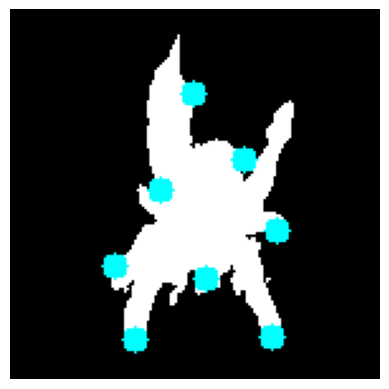

In [167]:
import cv2
import numpy as np


# Parameters
minimum_quality_score = 0.05  # adjust if too many/too few
minimum_distance = 30         # minimum distance between corners

# Detect corners — maxCorners=0 lets OpenCV decide how many
corners = cv2.goodFeaturesToTrack(
    edited,
    maxCorners=0,  # 0 means no limit
    qualityLevel=minimum_quality_score,
    minDistance=minimum_distance
)

# Count and optionally round corners
corner_count = 0
if corners is not None:
    corner_count = len(corners)
    corners = np.int16(corners)
cornered = edited.copy()
cornered = cv2.cvtColor(cornered, cv2.COLOR_GRAY2BGR)
for corner in corners:
    x, y = corner[0]
    cv2.circle(cornered, (x,y), 5, (0,255,255), -1)

print(f"Detected corners: {corner_count}")
plt.imshow(cornered), plt.axis("off")
plt.show()



(<matplotlib.image.AxesImage at 0x23985938730>, (-0.5, 145.5, 145.5, -0.5))

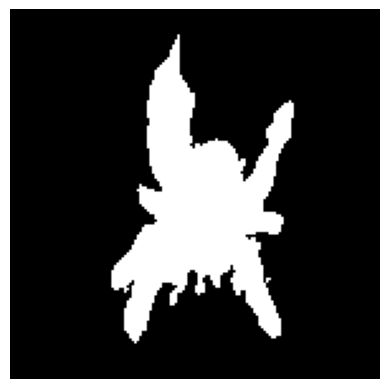

In [160]:
plt.imshow(edited, cmap = 'gray'), plt.axis("off")

In [54]:
import numpy as np
import cv2
import os
from segment_anything import SamPredictor
from openvino.runtime import Core
from tqdm import tqdm

def generate_spider_masks(ref_image_path, ref_point, image_paths, predictor: SamPredictor):
    """
    Generates masks in new images using a SAM predictor based on the reference point's embedding.

    Parameters:
    - ref_image_path: str, path to the reference image
    - ref_point: tuple of int (x, y), point on spider in the reference image
    - image_paths: list of str, paths to all target images
    - predictor: initialized SamPredictor

    Returns:
    - List of (image_path, mask) tuples
    """

    # Step 1: Load and embed reference image
    ref_image = cv2.imread(ref_image_path)
    ref_image = cv2.cvtColor(ref_image, cv2.COLOR_BGR2RGB)
    predictor.set_image(ref_image)

    # Get full image embedding
    ref_embedding = predictor.get_image_embedding().cpu().numpy()[0]  # shape [256, 64, 64]

    # Map point to embedding resolution
    h, w = ref_image.shape[:2]
    embed_h, embed_w = ref_embedding.shape[1:]
    embed_x = int(ref_point[0] * embed_w / w)
    embed_y = int(ref_point[1] * embed_h / h)

    # Extract reference embedding vector at the point
    spider_vec = ref_embedding[:, embed_y, embed_x]  # shape [256]
    spider_vec /= np.linalg.norm(spider_vec)

    results = []

    # Step 2: Iterate through dataset
    for img_path in tqdm(image_paths, desc="Generating masks"):
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        predictor.set_image(img_rgb)
        emb = predictor.get_image_embedding().cpu().numpy()[0]

        # Normalize embedding
        emb_norm = emb / np.linalg.norm(emb, axis=0, keepdims=True)

        # Cosine similarity with reference vector
        similarity = np.tensordot(spider_vec, emb_norm, axes=(0, 0))  # shape [64, 64]
        max_y, max_x = np.unravel_index(np.argmax(similarity), similarity.shape)

        # Map back to original image coordinates
        H, W = img.shape[:2]
        point_x = int(max_x * W / embed_w)
        point_y = int(max_y * H / embed_h)

        # Step 3: Predict mask
        input_point = np.array([[point_x, point_y]])
        input_label = np.array([1])
        masks, scores, _ = predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            multimask_output=True  # get multiple masks to choose from
        )

        # Pick the smallest mask by area
        best_idx = np.argmin([np.sum(mask) for mask in masks])
        results.append((img_path, masks[best_idx]))

    return results



In [128]:
directory = r"C:\Files\Araneus diadematus\Missing leg study\Missing leg treatment"
image_paths = []
for filename in os.listdir(directory):
    if filename.lower().endswith(".jpg"):
        image_paths.append(os.path.join(directory, filename))
#We already have the mask for this one        
image_paths.remove('C:\\Files\\Araneus diadematus\\Missing leg study\\Missing leg treatment\\9 - 1.jpg')
print(image_paths)


['C:\\Files\\Araneus diadematus\\Missing leg study\\Missing leg treatment\\19 - 1.JPG', 'C:\\Files\\Araneus diadematus\\Missing leg study\\Missing leg treatment\\19 - 2.JPG', 'C:\\Files\\Araneus diadematus\\Missing leg study\\Missing leg treatment\\19 - 3.JPG', 'C:\\Files\\Araneus diadematus\\Missing leg study\\Missing leg treatment\\19 - C.JPG', 'C:\\Files\\Araneus diadematus\\Missing leg study\\Missing leg treatment\\25 - 1.JPG', 'C:\\Files\\Araneus diadematus\\Missing leg study\\Missing leg treatment\\25 - 2.JPG', 'C:\\Files\\Araneus diadematus\\Missing leg study\\Missing leg treatment\\25 - 3.JPG', 'C:\\Files\\Araneus diadematus\\Missing leg study\\Missing leg treatment\\25 - C.JPG', 'C:\\Files\\Araneus diadematus\\Missing leg study\\Missing leg treatment\\26 - 1.JPG', 'C:\\Files\\Araneus diadematus\\Missing leg study\\Missing leg treatment\\26 - 2.JPG', 'C:\\Files\\Araneus diadematus\\Missing leg study\\Missing leg treatment\\26 - 3.JPG', 'C:\\Files\\Araneus diadematus\\Missing le

In [129]:
testPaths = [image_paths[0], image_paths[1],image_paths[2],image_paths[3], image_paths[4]]

In [130]:
ref_point = (2440, 840)
results = generate_spider_masks(ref_image_path = r'C:\\Files\\Araneus diadematus\\Missing leg study\\Missing leg treatment\\9 - 1.jpg' , ref_point = ref_point , image_paths = testPaths , predictor = predictor)

Generating masks: 100%|██████████| 5/5 [01:02<00:00, 12.53s/it]


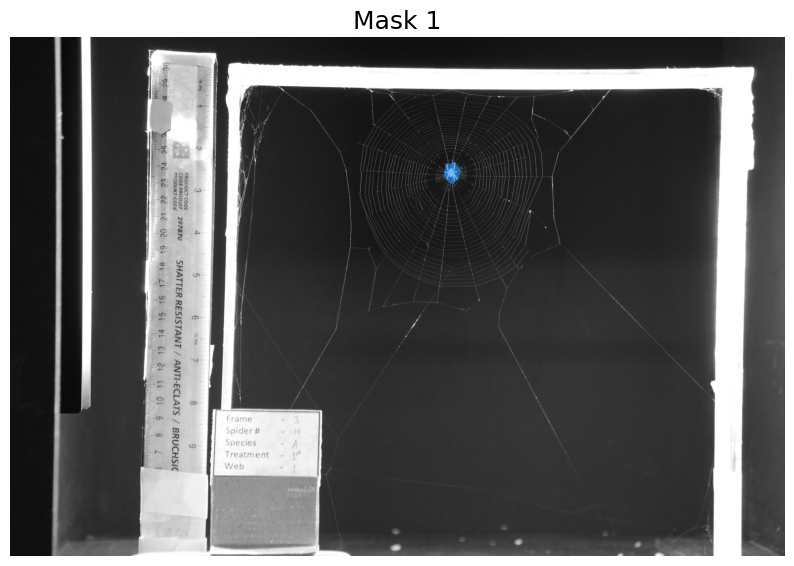

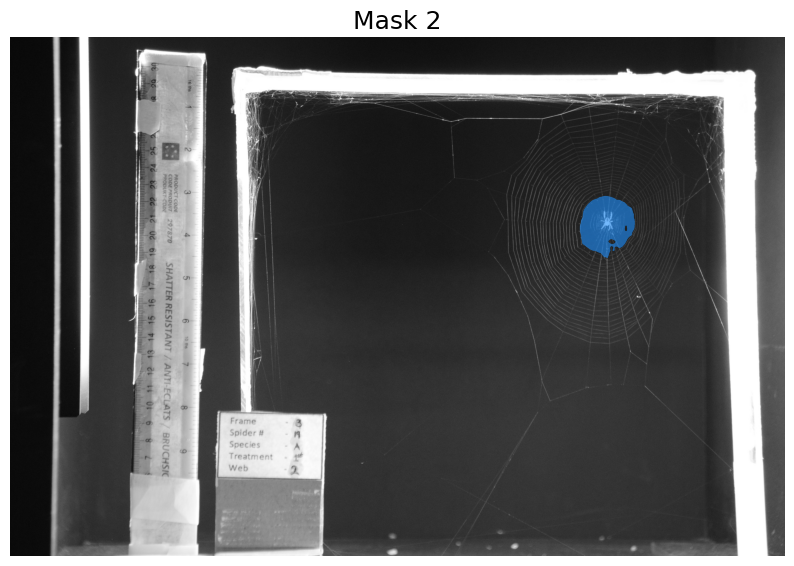

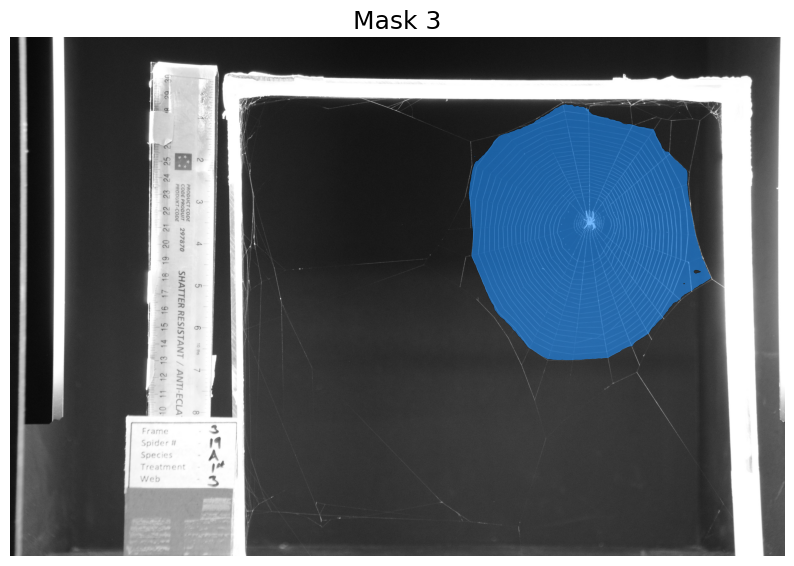

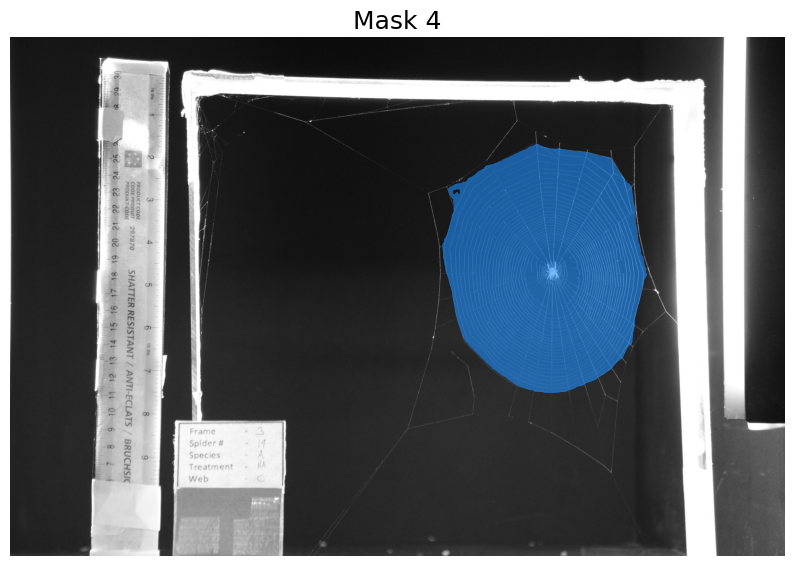

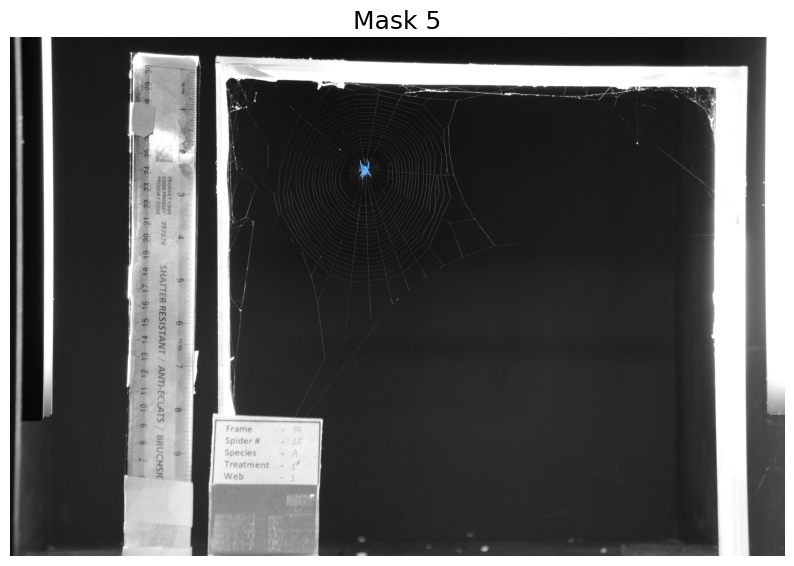

In [131]:
num = 0
for mask in results:
    im = cv2.imread(testPaths[num]) #Make sure to change this to your actual paths once you do the whole thing
    plt.figure(figsize=(10,10))
    plt.imshow(im)
    show_mask(mask[1], plt.gca())
    plt.title(f"Mask {num+1}", fontsize=18)
    plt.axis('off')
    plt.show()  
    num+=1

In [85]:
# Get the image embedding from SAM
predictor.set_image(pointImage)  # RGB numpy array
image_embedding = predictor.get_image_embedding().cpu().numpy()  # shape: [1, 256, H/16, W/16]

# Resize the mask to match embedding resolution
from skimage.transform import resize
H, W = image_embedding.shape[2:]
resized_mask = resize(reference, (H, W), order=0, preserve_range=True) > 0.5

# Extract spider feature vectors
spider_features = image_embedding[0, :, resized_mask]
spider_signature = spider_features.mean(axis=1)  # shape: (256,)


In [ ]:
# testIm = cv2.imread(r"C:\Files\Araneus diadematus\Missing leg study\Missing leg treatment\25 - 2.JPG")
# testIm = cv2.cvtColor(testIm, cv2.COLOR_BGR2RGB)
predictor.set_image(pointImage)
embedding = predictor.get_image_embedding().cpu().numpy()[0]  # shape: [256, H, W]

orig_h, orig_w = image.shape[:2]
embed_h, embed_w = embedding.shape[1:]

# Your original point
pt_x, pt_y = 2440, 840

# Map to embedding resolution
x_embed = int(pt_x * embed_w / orig_w)
y_embed = int(pt_y * embed_h / orig_h)

# Extract feature vector
signature = embedding[:, y_embed, x_embed]  # shape: (256,)
signature = signature / np.linalg.norm(signature)  # normalize


# # Compute cosine similarity between spider_signature and every location
# from numpy.linalg import norm

# # Normalize
# normed_signature = spider_signature / norm(spider_signature)
# normed_embedding = new_embedding / norm(new_embedding, axis=0, keepdims=True)

# # Dot product = cosine similarity
# similarity_map = (normed_signature[:, None, None] * normed_embedding).sum(axis=0)


# from numpy.linalg import norm

# # Assume `ref_embedding` is (256, 64, 64)
# # Get the embedding at your point (in 64x64 space)
# y, x = point_in_64x64_space  # e.g., from the first successful mask

# signature = ref_embedding[:, y, x]  # shape: (256,)

# # Normalize
# normed_signature = signature / norm(signature)

# # Normalize the whole test embedding
# normed_embedding = test_embedding / norm(test_embedding, axis=0, keepdims=True)  # shape: (256, 64, 64)

# # Compute cosine similarity map
# similarity_map = (normed_signature[:, None, None] * normed_embedding).sum(axis=0)  # shape: (64, 64)



In [89]:
# Normalize the new embedding along channel axis
testIm = cv2.imread(r"C:\Files\Araneus diadematus\Missing leg study\Missing leg treatment\25 - 2.JPG")
testIm = cv2.cvtColor(testIm, cv2.COLOR_BGR2RGB)
predictor.set_image(testIm)
new_embedding = predictor.get_image_embedding().cpu().numpy()[0]  # shape: [256, H, W]
normed_new_embedding = new_embedding / np.linalg.norm(new_embedding, axis=0, keepdims=True)

# Compute cosine similarity
similarity_map = (signature[:, None, None] * normed_new_embedding).sum(axis=0)  # shape: (64, 64)

# Find the best match
y_max, x_max = np.unravel_index(np.argmax(similarity_map), similarity_map.shape)

# Map back to original image resolution
new_h, new_w = testIm.shape[:2]
x_orig = int(x_max * new_w / similarity_map.shape[1])
y_orig = int(y_max * new_h / similarity_map.shape[0])


In [90]:
# Find the highest similarity point
max_y, max_x = np.unravel_index(np.argmax(similarity_map), similarity_map.shape)

# Upscale to original resolution
orig_h, orig_w = testIm.shape[:2]
point = (int(max_x * orig_w / similarity_map.shape[1]),
         int(max_y * orig_h / similarity_map.shape[0]))

# Segment using this point
input_point = np.array([point])
input_label = np.array([1])

masks, scores, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False
)


In [91]:
input_point = np.array([[x_orig, y_orig]])
input_label = np.array([1])  # foreground

masks, scores, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False
)


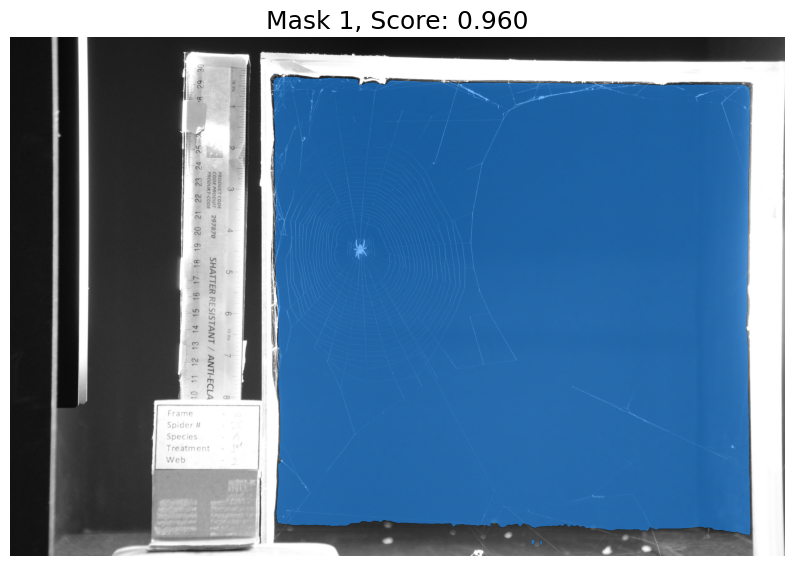

In [94]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(testIm)
    show_mask(mask, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

In [ ]:
import torch
from sam2.sam2_image_predictor import SAM2ImagePredictor


predictor = SAM2ImagePredictor.from_pretrained("facebook/sam2-hiera-large")

with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    predictor.set_image(image)
    #masks, _, _ = predictor.predict(<input_prompts>)

c:\Users\adamain\.conda\envs\imgid\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AssertionError: Torch not compiled with CUDA enabled

In [12]:
IMG_SIZE = 256

image_paths =  glob.glob("D:/Gabriel_Lopez/project/segmentation/dataset/non-aug/train//images/*.tif")
masks_paths = glob.glob("D:/Gabriel_Lopez/project/segmentation/dataset/non-aug/train/mask/*.tiff")

allImages = []
allMasks = []
for imgFile, imgMask, in tqdm(zip(image_paths, masks_paths), total=len(image_paths)):
  img = cv2. imread(imgFile)
  img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
  img = img/255.0
  allImages.append(img)

  mask = cv2.imread(imgMask, cv2.IMREAD_GRAYSCALE)
  mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
  mask[mask > 0] = 1
  allMasks.append(mask)



images = np.array(allImages)
masks = np.array(allMasks)
masks= masks.astype(np.uint8)
print(images.shape)
print(masks.shape)

100%|██████████| 216/216 [00:06<00:00, 31.12it/s]


(216, 256, 256, 3)
(216, 256, 256)


In [14]:
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray((img * 255).astype(np.uint8)) for img in images],
    "label": [Image.fromarray(mask) for mask in masks],
}

In [15]:
from datasets import Dataset
# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


dataset

c:\Users\fract\anaconda3\envs\worms\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset({
    features: ['image', 'label'],
    num_rows: 216
})

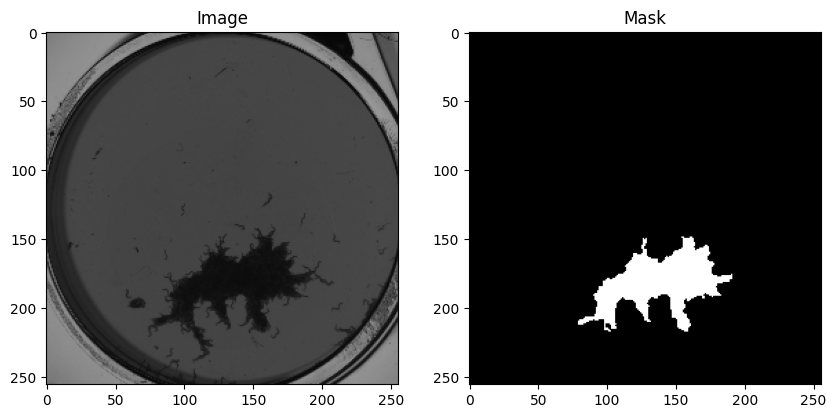

In [16]:
img_num = random.randint(0, images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")
# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Display the images side by side
plt.show()

In [68]:
example_image.shape()

AttributeError: 'PngImageFile' object has no attribute 'shape'

In [17]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [18]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])
    
    # Convert the image to RGB format
    #image = image.convert("RGB") #This line was added to make sure images are read in expected format

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [19]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [20]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [21]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)


In [22]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


c:\Users\fract\anaconda3\envs\worms\Lib\site-packages\transformers\image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)


In [23]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

In [24]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [26]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [42]:
! set CUDA_HOME=C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.8
! set PATH=%CUDA_HOME%\bin;%CUDA_HOME%\libnvvp;%PATH%

In [9]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print("GPUs Available:", gpus)

GPUs Available: []


In [10]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 938911069328143034
xla_global_id: -1
]


In [27]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
#Training loop
num_epochs = 10

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

  0%|          | 0/108 [00:00<?, ?it/s]c:\Users\fract\anaconda3\envs\worms\Lib\site-packages\transformers\image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)
100%|██████████| 108/108 [06:04<00:00,  3.38s/it]


EPOCH: 0
Mean loss: 0.28077647196887817


100%|██████████| 108/108 [06:03<00:00,  3.37s/it]


EPOCH: 1
Mean loss: 0.16294018187801595


100%|██████████| 108/108 [06:03<00:00,  3.37s/it]


EPOCH: 2
Mean loss: 0.14137398099733722


100%|██████████| 108/108 [06:04<00:00,  3.38s/it]


EPOCH: 3
Mean loss: 0.13152219186088554


100%|██████████| 108/108 [06:05<00:00,  3.38s/it]


EPOCH: 4
Mean loss: 0.12232539617387508


100%|██████████| 108/108 [06:04<00:00,  3.37s/it]


EPOCH: 5
Mean loss: 0.11441676379008978


100%|██████████| 108/108 [06:04<00:00,  3.38s/it]


EPOCH: 6
Mean loss: 0.10976665418733049


100%|██████████| 108/108 [06:05<00:00,  3.38s/it]


EPOCH: 7
Mean loss: 0.10433707543200364


100%|██████████| 108/108 [06:04<00:00,  3.37s/it]


EPOCH: 8
Mean loss: 0.10213419172429929


100%|██████████| 108/108 [06:04<00:00,  3.38s/it]

EPOCH: 9
Mean loss: 0.09924268924320738


In [28]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "D:/Gabriel_Lopez/project/segmentation/dataset/non-aug/train//models/model_great_checkpoint.pth")

In [29]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("D:/Gabriel_Lopez/project/segmentation/dataset/non-aug/train//models/model_great_checkpoint.pth"))

<All keys matched successfully>

In [30]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

c:\Users\fract\anaconda3\envs\worms\Lib\site-packages\transformers\image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)


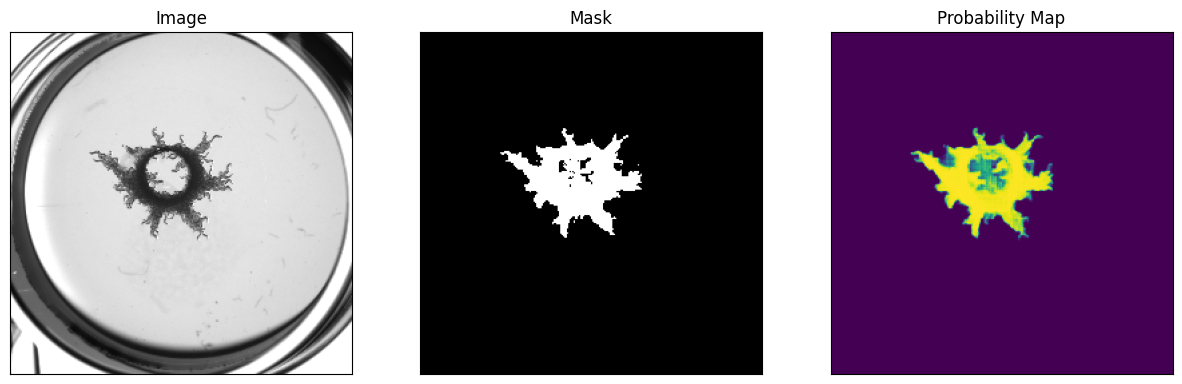

In [55]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, images.shape[0]-1)

# load image
test_image = dataset[idx]["image"]
#test_image = test_image.convert("RGB")

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
plt.subplot(1, 3, 1)
plt.imshow(np.array(test_image), cmap='gray')
plt.title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
# Display the images side by side
plt.show()

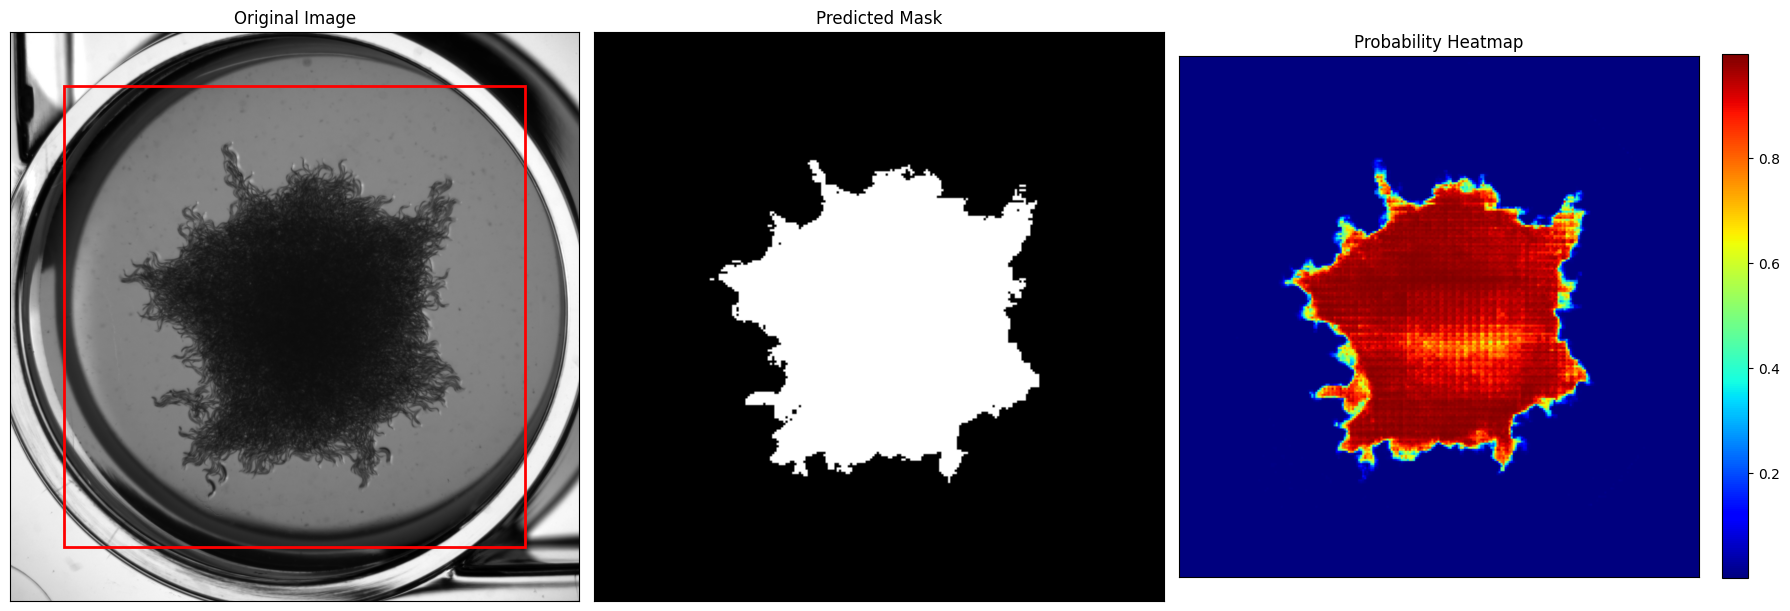

In [100]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

# Path to your new image
image_path = "D:/Gabriel_Lopez/project/segmentation/dataset/non-aug/validation/images2/Test 6-22-24_Series001_t019_ch00.tif"

# Load and preprocess the image
def load_and_preprocess(image_path):
    # Read as grayscale but convert to RGB-like format for SAM
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Handle 16-bit TIFF normalization if needed
    if img.dtype == np.uint16:
        img = cv2.convertScaleAbs(img, alpha=(255.0/65535.0))
    
    # Convert to 3-channel "RGB" by stacking grayscale channels
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    return img_rgb, img  # Return both RGB and original grayscale

# Load your image
test_image, original_grayscale = load_and_preprocess(image_path)

def auto_detect_prompt(gray_image, scale_factor=0.81):  # Reduce size depends on your image
    _, thresh = cv2.threshold(gray_image, 0, 255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) > 0:
        c = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(c)
        
        # Compute center of the bounding box
        center_x, center_y = x + w // 2, y + h // 2

        # Reduce the bounding box size
        new_w, new_h = int(w * scale_factor), int(h * scale_factor)

        # Compute new top-left and bottom-right coordinates
        new_x1 = max(center_x - new_w // 2, 0)
        new_y1 = max(center_y - new_h // 2, 0)
        new_x2 = min(center_x + new_w // 2, gray_image.shape[1])
        new_y2 = min(center_y + new_h // 2, gray_image.shape[0])

        return [new_x1, new_y1, new_x2, new_y2]
    else:
        h, w = gray_image.shape
        return [w//4, h//4, 3*w//4, 3*h//4]  # Default case

# Get automatic prompt (modify this logic based on your needs)
prompt = auto_detect_prompt(original_grayscale)

# Prepare inputs for SAM model
inputs = processor(
    Image.fromarray(test_image),  # Convert to PIL Image
    input_boxes=[[prompt]],       # Use detected bounding box
    return_tensors="pt"
).to(device)

# Run inference
my_mito_model.eval()
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# Process outputs
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
medsam_seg = (medsam_seg_prob > 0.5).float().cpu().numpy().squeeze()
medsam_seg_prob = medsam_seg_prob.detach().cpu().numpy().squeeze()

# Visualization with bounding box overlay
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original Image
axes[0].imshow(original_grayscale, cmap='gray')
axes[0].set_title("Original Image")
axes[0].add_patch(plt.Rectangle((prompt[0], prompt[1]),
                              prompt[2]-prompt[0],
                              prompt[3]-prompt[1],
                              fill=False, edgecolor='red', linewidth=2))

# Predicted Mask
axes[1].imshow(medsam_seg, cmap='gray')
axes[1].set_title("Predicted Mask")

# Probability Map
prob_map = axes[2].imshow(medsam_seg_prob, cmap='jet')
plt.colorbar(prob_map, ax=axes[2], fraction=0.046, pad=0.04)
axes[2].set_title("Probability Heatmap")

# Formatting
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

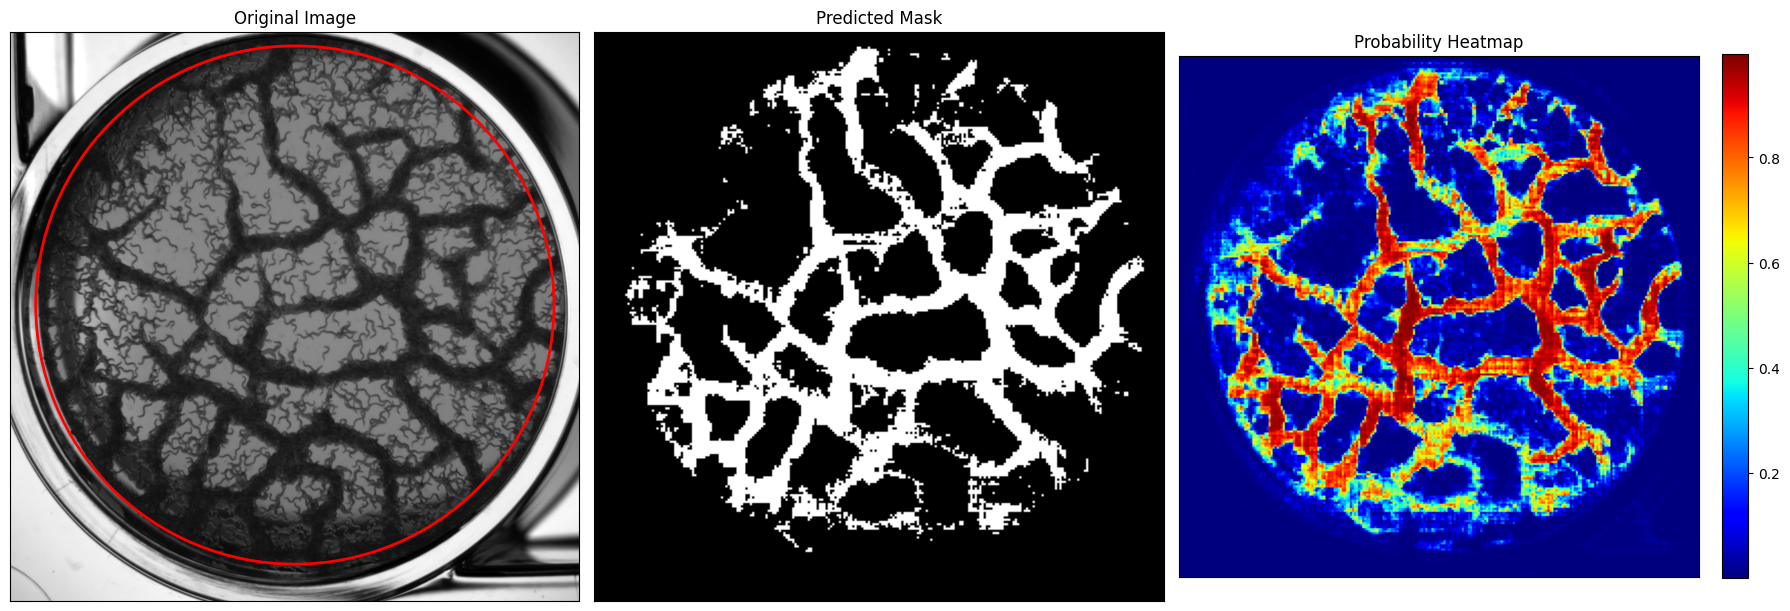

In [113]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

# Path to your new image
image_path = "D:/Gabriel_Lopez/project/segmentation/dataset/non-aug/validation/images2/Test 6-22-24_Series001_t322_ch00.tif"

# Load and preprocess the image
def load_and_preprocess(image_path):
    # Read as grayscale but convert to RGB-like format for SAM
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Handle 16-bit TIFF normalization if needed
    if img.dtype == np.uint16:
        img = cv2.convertScaleAbs(img, alpha=(255.0/65535.0))
    
    # Convert to 3-channel "RGB" by stacking grayscale channels
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    return img_rgb, img  # Return both RGB and original grayscale

# Load your image
test_image, original_grayscale = load_and_preprocess(image_path)

# Function to detect a circular bounding region
def auto_detect_prompt(gray_image, scale_factor=0.98, x_offset=0, y_offset=0):  
    _, thresh = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) > 0:
        c = max(contours, key=cv2.contourArea)
        (x, y), radius = cv2.minEnclosingCircle(c)  # Get enclosing circle
        
        # Apply manual shift
        return int(x) + x_offset, int(y) + y_offset, int(radius * scale_factor)
    else:
        # Default: center of image with estimated radius
        h, w = gray_image.shape
        return w // 2, h // 2, min(w, h) // 6  # Center with 1/4th image size

# Adjust these values to move the circle
x_shift = 120  # Move right (negative to move left)
y_shift = 100 # Move up (positive to move down)

# Get the adjusted circular prompt
cx, cy, r = auto_detect_prompt(original_grayscale, scale_factor=0.76, x_offset=x_shift, y_offset=y_shift)

# Prepare inputs for SAM model
inputs = processor(
    Image.fromarray(test_image),  # Convert to PIL Image
    input_boxes=[[[cx - r, cy - r, cx + r, cy + r]]],  # Convert circle to bounding box format
    return_tensors="pt"
).to(device)

# Run inference
my_mito_model.eval()
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# Process outputs
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
medsam_seg = (medsam_seg_prob > 0.45).float().cpu().numpy().squeeze()
medsam_seg_prob = medsam_seg_prob.detach().cpu().numpy().squeeze()

# Visualization with circular bounding region
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original Image
axes[0].imshow(original_grayscale, cmap='gray')
axes[0].set_title("Original Image")

# Draw circle instead of rectangle
circle = plt.Circle((cx, cy), r, color='red', fill=False, linewidth=2)
axes[0].add_patch(circle)

# Predicted Mask
axes[1].imshow(medsam_seg, cmap='gray')
axes[1].set_title("Predicted Mask")

# Probability Map
prob_map = axes[2].imshow(medsam_seg_prob, cmap='jet')
plt.colorbar(prob_map, ax=axes[2], fraction=0.046, pad=0.04)
axes[2].set_title("Probability Heatmap")

# Formatting
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


In [60]:
import numpy as np

# Assuming medsam_seg_prob is your probability heatmap
# Define the probability range I am interested in
lower_prob = 0.5  # Example lower bound
upper_prob = 1.0  # Example upper bound

# Create a binary mask for the specified probability range
prob_mask = (medsam_seg_prob >= lower_prob) & (medsam_seg_prob <= upper_prob)

# Calculate the area by counting the pixels in the mask
area_pixels = np.sum(prob_mask)

# If you know the area each pixel represents (e.g., in square meters), you can calculate the total area
pixel_area = 1.0  # Replace with the actual area per pixel (e.g., in square meters)
total_area = area_pixels * pixel_area

print(f"Area of probability range [{lower_prob}, {upper_prob}]: {total_area} square units")

Area of probability range [0.5, 1.0]: 13653.0 square units


In [66]:
area_pixels.shape

()